# Week10 - Part2: OCR for Reading Bottle Number

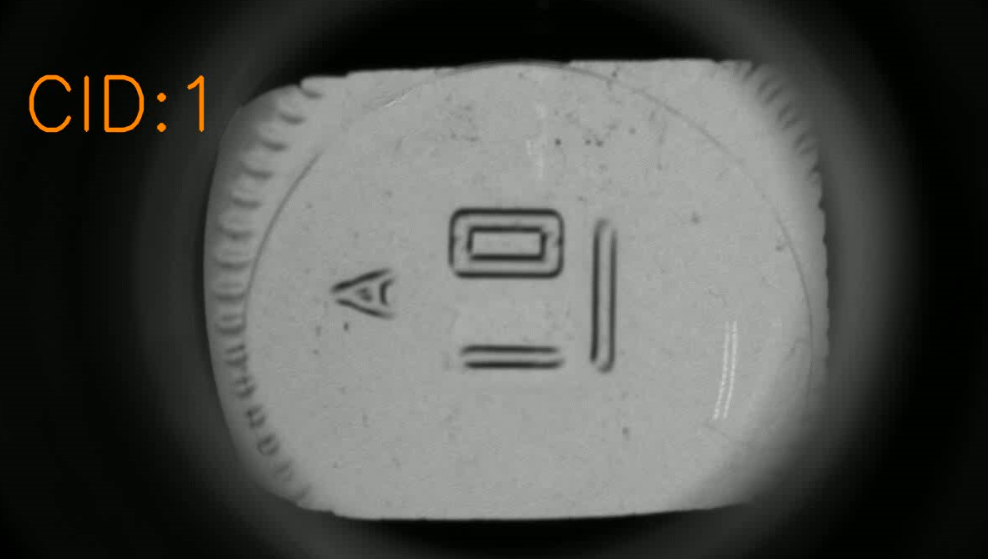

In [3]:
import cv2
import numpy as np
import easyocr
import glob # เพิ่มไลบรารีนี้สำหรับอ่านไฟล์ในโฟลเดอร์
import os
from PIL import ImageFont, ImageDraw, Image

# Initialize the Reader for Thai ('th') and English ('en')
reader = easyocr.Reader(['en'])

In [ ]:
# #OCR Processing in function run_ocr() 
# def run_ocr(orig):

#     # Extract text and bounding box coordinates from the original image
#     results = reader.readtext(orig)
    
#     # Convert BGR to RGB
#     img_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)


#     # Convert OpenCV format to PIL
#     pil_img = Image.fromarray(img_rgb)
#     # Initialize the drawing context for the PIL image
#     draw = ImageDraw.Draw(pil_img) 
#     # Load THSarabunNew font
#     font = ImageFont.truetype(r"C:\Users\jinny\Desktop\cv\font\THSarabunNew.ttf", 40)


#     # Loop for drawing bounding boxes and text
#     for (bbox, text, prob) in results:
#         #Unpack the bounding box
#         (tl, tr, br, bl) = bbox
#         #Convert float coordinates to int tuble
#         tl = tuple(map(int, tl))# Top left (w)
#         br = tuple(map(int, br))# Botton right (y)

#         # Draw rectangle (OpenCV style แต่ต้องวาดบน PIL)
#         draw.rectangle([tl, br], outline=(0, 255, 0), width=2)# Green color for bounding box
#         # Draw Thai text
#         draw.text(tl, str(text), font = font, fill = (0, 0, 255)) # Red color for text

     
#     # Return image as a PIL object 
#     return pil_img
   

In [6]:
def preprocess_for_ocr(img):
    # 1. ขยายภาพ 2 เท่า
    enlarged = cv2.resize(img, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
    
    # 2. แปลงเป็นขาวดำ (Grayscale)
    gray = cv2.cvtColor(enlarged, cv2.COLOR_BGR2GRAY)
    
    # 3. เบลอภาพนิดหน่อยเพื่อลบรอยขรุขระบนพลาสติก (Noise)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # 4. ดึง Contrast ให้เงาของตัวหนังสือปั๊มนูนเข้มขึ้น
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
    enhanced = clahe.apply(blurred)
    
    # 5. ถมดำ (Erosion) บนภาพ Grayscale โดยตรง
    # วิธีนี้จะทำให้ "เงาสีเข้ม" ของตัวอักษรขยายตัวหนาขึ้นโดยไม่ทำให้ตัวหนังสือแตก
    morph_kernel = np.ones((3,3), np.uint8)
    thickened = cv2.erode(enhanced, morph_kernel, iterations=1)
    
    return thickened, enlarged
def run_ocr(orig):
    # นำภาพไป Preprocess ก่อนส่งให้ OCR
    processed_img, enlarged_orig = preprocess_for_ocr(orig)
    
    # ส่งภาพที่ผ่านการปรับแต่งแล้วให้ EasyOCR
    # แนะนำให้เพิ่ม allowlist ถ้าทราบว่าตัวอักษรมีแค่ภาษาอังกฤษและตัวเลข
    results = reader.readtext(processed_img, allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789', width_ths=0.8)
    
    # Convert OpenCV format (BGR) to PIL (RGB) for drawing
    img_rgb = cv2.cvtColor(enlarged_orig, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)
    draw = ImageDraw.Draw(pil_img) 

    img_h = img_rgb.shape[0]
    
    # Load THSarabunNew font
    try:
        font = ImageFont.truetype(r"C:\Users\jinny\Desktop\cv\font\THSarabunNew.ttf", 40)
    except IOError:
        print("Warning: Font not found, using default.")
        font = ImageFont.load_default()

    # Loop for drawing bounding boxes and text
    for (bbox, text, prob) in results:
       if prob < 0.2 or len(text) == 0: 
            continue
            
        (tl, tr, br, bl) = bbox
        tl = tuple(map(int, tl))
        br = tuple(map(int, br))
        
        # --- [ลอจิกใหม่: แบ่งโซนบนล่าง] ---
        # หาพิกัดตรงกลางของกล่องในแนวตั้ง (แกน Y)
        center_y = (tl[1] + br[1]) / 2
        
        # ถ้าตำแหน่งกล่องอยู่ "ครึ่งบน" ของภาพ
        if center_y < img_h / 2:
            # ครึ่งบนต้องเป็นตัวอักษร 1 ตัวแน่ๆ ดังนั้นดึงมาแค่ตัวแรก (แก้ปัญหา A อ่านเป็น AA)
            clean_text = text[0] 
        else:
            # ครึ่งล่างต้องเป็นตัวเลข ให้แทนที่ตัวอักษรที่ AI มักจะสับสน
            clean_text = text.replace('V', '1').replace('v', '1').replace('l', '1').replace('I', '1')
            clean_text = clean_text.replace('O', '0').replace('o', '0').replace('U', '0')
            clean_text = clean_text.replace('b', '6').replace('B', '6')
        # วาดกรอบสีเขียว
        draw.rectangle([tl, br], outline=(0, 255, 0), width=10)
        # วาดตัวหนังสือสีแดง (ใน PIL ใช้ RGB สีแดงคือ (255, 0, 0))
        draw.text(tl, str(clean_text), font=font, fill=(255, 0, 0)) 

    # แปลงกลับเป็น numpy array แบบ BGR เพื่อให้ cv2.imshow แสดงสีได้ถูกต้อง
    result_cv2 = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
    final_result = cv2.resize(result_cv2, (orig.shape[1], orig.shape[0]), interpolation=cv2.INTER_AREA)
    
    return final_result

IndentationError: unindent does not match any outer indentation level (<string>, line 48)

In [5]:
base_folder = r"C:\Users\jinny\Desktop\cv\Bottle Number"

while True:
    print("-" * 50)
    # 1. รับค่าแค่ตัวเลขจากผู้ใช้งาน เช่น 01, 02
    file_num = input("กรุณาใส่หมายเลข (เช่น 01) หรือพิมพ์ 'q' เพื่อออก: ")
    
    if file_num.lower() == 'q':
        print("ออกจากโปรแกรม...")
        break
        
    # ลบช่องว่างเผื่อเผลอกด Spacebar ท้ายตัวเลข
    file_num = file_num.strip()

    # ประกอบร่างชื่อไฟล์ (อิงจากชื่อไฟล์เดิมของคุณคือ num01_0.jpg)
    img_name = f"num{file_num}_0.jpg"
    
    # รวมโฟลเดอร์กับชื่อไฟล์เข้าด้วยกันเป็น Path เต็ม
    img_path = os.path.join(base_folder, img_name)

    # 2. อ่านไฟล์รูป
    img = cv2.imread(img_path)

    # เช็คว่าหาไฟล์เจอไหม
    if img is None:
        print(f"❌ Error: หาไฟล์ไม่เจอ ตรวจสอบว่ามีไฟล์ {img_name} อยู่ในโฟลเดอร์ไหม")
        print(f"Path ที่ค้นหา: {img_path}")
        continue 
        
    print(f"⏳ กำลังประมวลผลไฟล์: {img_name} ...")

    # --- 3. ตัดภาพ (Crop) ตามกรอบเส้นสีแดง (ทำตอนภาพเป็นแนวนอน) ---
    h, w = img.shape[:2]
    
    y_start = int(h * 0.20)  
    y_end = int(h * 0.80)    
    x_start = int(w * 0.25)  
    x_end = int(w * 0.75)    
    
    cropped_img = img[y_start:y_end, x_start:x_end]

    # --- 4. หมุนและกลับด้านภาพที่ถูกตัดมาแล้ว ---
    rotated_img = cv2.rotate(cropped_img, cv2.ROTATE_90_CLOCKWISE)
    final_img = cv2.flip(rotated_img, 1)

    # --- 5. นำภาพไปรัน OCR ---
    result_img = run_ocr(final_img)

    # --- 6. แสดงผลลัพธ์ ---
    window_name = f'OCR Result: {img_name}'
    
    cv2.imshow(window_name, result_img)
    print("✅ ประมวลผลเสร็จแล้ว! (กดปุ่มอะไรก็ได้บนหน้าต่างรูปเพื่อปิด และรันรูปต่อไป)")

    # รอรับการกดคีย์บอร์ดเพื่อปิดหน้าต่าง
    cv2.waitKey(0)
    cv2.destroyAllWindows()

--------------------------------------------------
⏳ กำลังประมวลผลไฟล์: num89_0.jpg ...
✅ ประมวลผลเสร็จแล้ว! (กดปุ่มอะไรก็ได้บนหน้าต่างรูปเพื่อปิด และรันรูปต่อไป)
--------------------------------------------------
ออกจากโปรแกรม...
